# LCI Analysis

In [1]:
%load_ext autoreload
%autoreload 2


import sys, os
import pickle
from collections import defaultdict, Counter

import numpy as np
import matplotlib.pyplot as plt 
import torch
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import networkx as nx
from tqdm import tqdm_notebook as tqdm
import goatools
from goatools.base import download_go_basic_obo, download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.associations import read_ncbi_gene2go
from goatools.go_enrichment import GOEnrichmentStudy
#from tqdm import tqdm_notebook as tqdm

from dpp.data.network import PPINetwork
from dpp.data.go import load_go_annotations
from dpp.data.drug import load_drug_targets
from dpp.util import Params, prepare_sns, load_mapping, build_degree_buckets, compute_pvalue
from dpp.data.associations import load_diseases

os.chdir("/Users/sabrieyuboglu/Documents/School/SNAP/projects/disease-protein-prediction")
#os.chdir("/dfs/scratch0/sabri/disease-protein-prediction")
prepare_sns(sns)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load Data

In [2]:
diseases = load_diseases("data/associations/disgenet-associations.csv", exclude_splits=["none"])
entrez_to_name = load_mapping("data/protein/symbol_to_entrez.txt", "\t", reverse=True,
                              b_transform=int)

In [3]:
network = PPINetwork("data/networks/bio-pathways-network.txt")

In [4]:
experiment_dir = "experiments/dpp_predict/lci_new"

In [5]:
base_params={
    "ppi_network": "data/networks/bio-pathways-network.txt",
    
    "diseases_path": "data/associations/disgenet-associations.csv",
    "disease_subset": [],
    
    "model_path": "experiments/dpp_predict/lci_new/"
}

### Load Weights
Specify a split from which to load weights

In [6]:
with open(os.path.join(experiment_dir, "models", "models.tar"), "rb") as f:
    split_to_model = pickle.load(f)

In [7]:
dicts = []
for split in tqdm(range(10)):
    model = split_to_model[split]
    model_stats = {
        "weight": model['linear_layer.weight'].item(), 
        "bias": model['linear_layer.bias'].item(), 
        "mean_z": np.mean(model['ci_weight'][0, 0].numpy())
    }
    dicts.append(model_stats)
model_df = pd.DataFrame(dicts, columns=["weight", "bias", "mean_z"])
model_df

,weight,bias,mean_z
0,17.550322,-0.811245,0.241408
1,17.876070,-0.723686,0.220373
2,16.029150,-1.334732,0.229375
3,16.782249,-0.696910,0.212054
4,18.501001,-1.084714,0.215662
5,15.429231,-1.496836,0.192651
6,16.680628,-0.571429,0.226772
7,12.891609,-1.300265,0.302289
8,17.751625,-0.990272,0.245099
9,16.344975,-0.574154,0.196769


In [8]:
ci_weights = np.mean([model['ci_weight'][0, 0].numpy() for model in split_to_model.values()], axis=0)
degrees = np.array(list(dict(network.nx.degree()).values()))
ci_weights_norm = ci_weights / (np.sqrt(degrees))

In [9]:
# save pandas file, 
protein_to_weight = {}
for node, weight in enumerate(ci_weights_norm):
    protein = network.get_protein(node)
    protein_to_weight[protein] = weight
df = pd.DataFrame.from_dict(protein_to_weight, orient="index")
df.to_csv(os.path.join(experiment_dir, "norm_weights.csv"))

## Weight Distribution

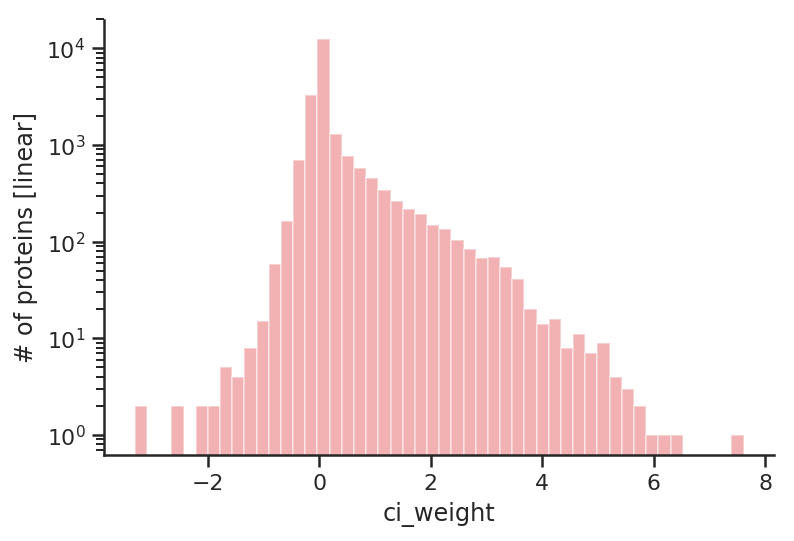

In [9]:
sns.distplot(ci_weights, kde=False)
plt.yscale('log')
plt.xlabel("ci_weight")
plt.ylabel("# of proteins [linear]")
sns.despine()

## Network Properties

### Degree


In [12]:
degrees = np.array(list(dict(network.nx.degree()).values()))

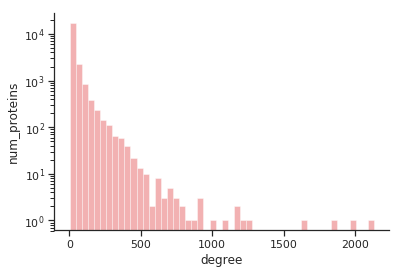

In [10]:
sns.distplot(degrees, kde=False)
plt.yscale('log')
plt.xlabel("degree")
plt.ylabel("num_proteins")
sns.despine()

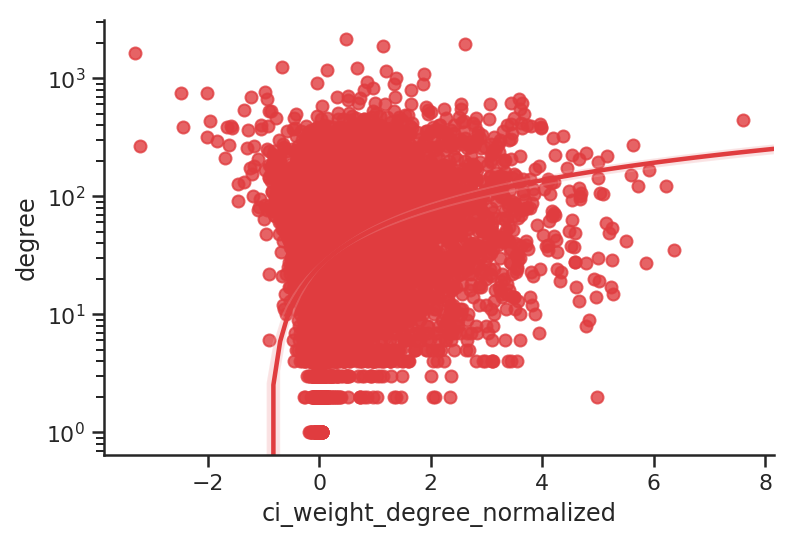

In [116]:
sns.regplot(ci_weights, degrees)
plt.yscale('log')
plt.ylabel("degree")
plt.xlabel("ci_weight_degree_normalized")
sns.despine()

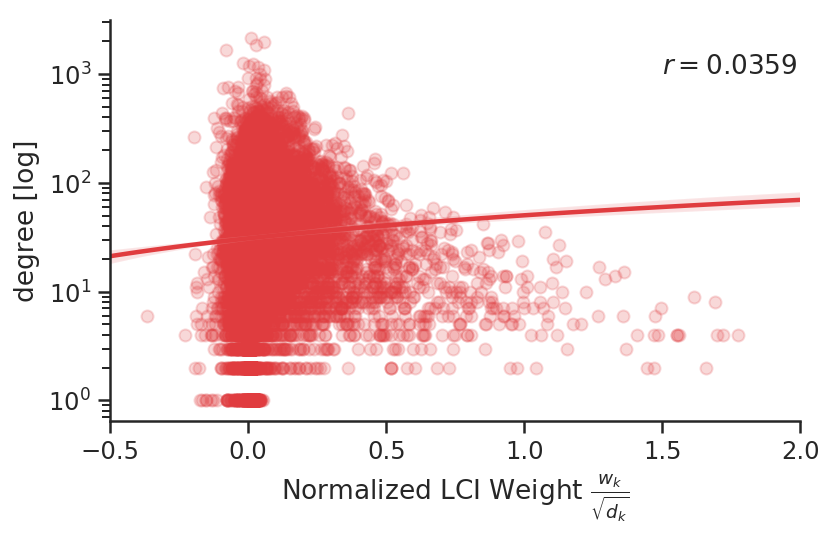

In [41]:
prepare_sns(sns, kwargs={"font_scale": 1.1,
                         "rc": {'figure.figsize':(6, 4)}})
sns.regplot(ci_weights / (np.sqrt(degrees)), degrees, scatter_kws={"alpha": 0.2})
r = pearsonr(ci_weights / np.sqrt(degrees), degrees)[0]
plt.text(1.5, 1000, rf'$r = {round(r, 4)}$')
plt.yscale('log')
plt.ylabel("degree [log]")
plt.xscale('linear')
plt.xlim([-1/2, 2])
plt.xlabel(r"Normalized LCI Weight $\frac{w_k}{\sqrt{d_k}}$")
sns.despine()
plt.tight_layout()
plt.savefig('experiments/lci_analysis/degree/deg_v_weight.pdf')

In [13]:
degree_df = pd.DataFrame({"degree": degrees,
                          "ci_weight": ci_weights})
mean_degree_df = degree_df.groupby("degree").mean()

Text(0, 0.5, 'mean normalized weight')

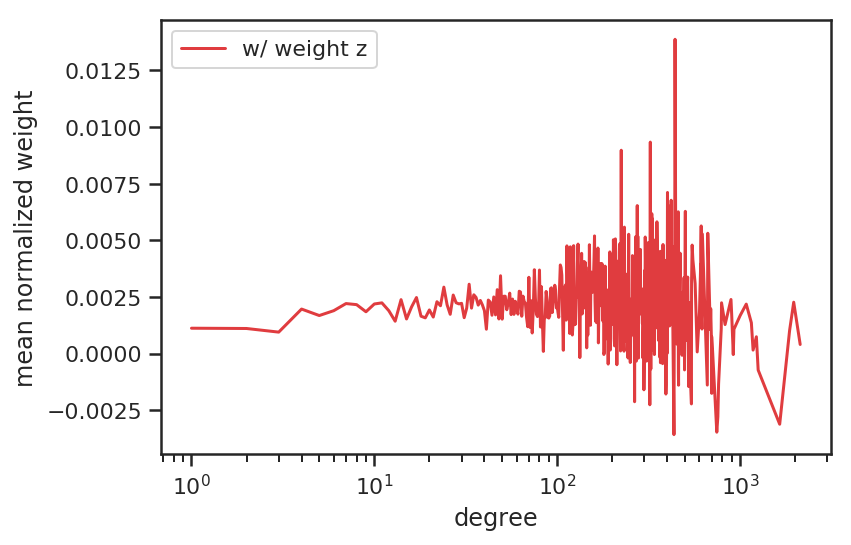

In [19]:
mean_degree_df = degree_df.groupby("degree").mean()
mean_norm_weights = mean_degree_df["ci_weight"] / np.power(mean_degree_df.index, 1/2) #/np.sqrt(mean_degree_df.index) # normalize by degree
mean_norm_weights = mean_norm_weights / mean_norm_weights.sum()
sns.lineplot(x=mean_degree_df.index, y=mean_norm_weights, label='w/ weight z')
y = 1/np.power(mean_degree_df.index, 1/2)
y = y/y.values.sum()
#sns.lineplot(x=mean_degree_df.index, y=y, label='w/o weight z')
plt.xscale('log')
plt.yscale('linear')
plt.xlabel('degree')
plt.ylabel('mean normalized weight')

In [24]:
from scipy.stats import pearsonr

In [26]:
pearsonr(ci_weights, degrees)

(0.268278675919948, 0.0)

### Triangle Clustering Coefficient

In [11]:
triangles = nx.clustering(network.nx)

In [12]:
triangles = np.array(list(triangles.values()))

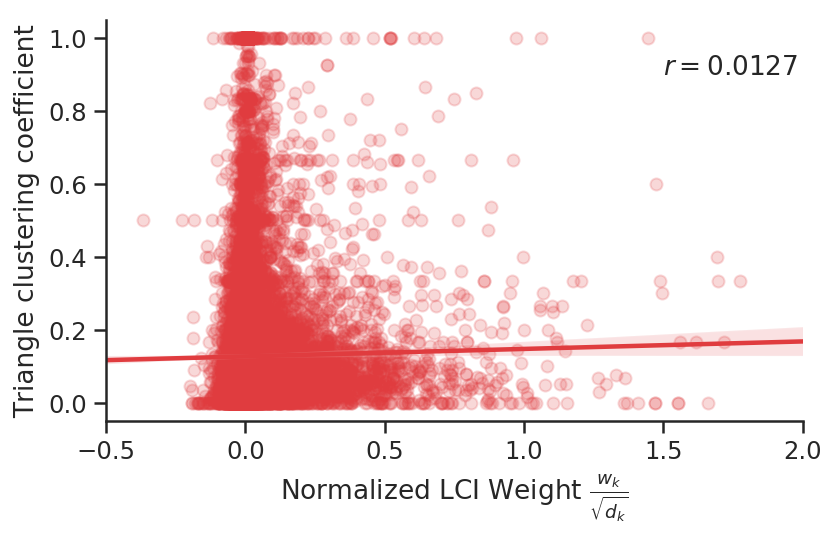

In [40]:
prepare_sns(sns, kwargs={"font_scale": 1.1,
                         "rc": {'figure.figsize':(6, 4)}})
sns.regplot(ci_weights / np.sqrt(degrees), triangles, scatter_kws={"alpha": 0.2})
r = pearsonr(ci_weights / np.sqrt(degrees), triangles)[0]
plt.text(1.5, 0.9, f'$r = {round(r, 4)}$')
plt.yscale('linear')
plt.ylabel("Triangle clustering coefficient")
plt.xscale('linear')
plt.xlim([-1/2, 2])
plt.xlabel(r"Normalized LCI Weight $\frac{w_k}{\sqrt{d_k}}$")
sns.despine()
plt.tight_layout()
plt.savefig('experiments/lci_analysis/triangle/triangle_v_weight.pdf')

#### Square Clustering Coefficient

In [72]:
squares = nx.square_clustering(network.nx)
squares = np.array(list(squares.values()))

In [83]:
squares[5185] = 0.0

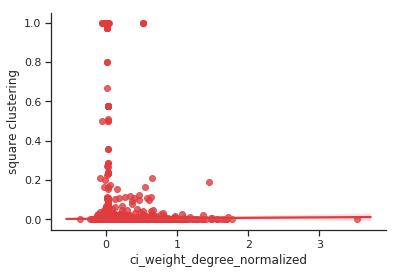

In [84]:
sns.regplot(ci_weights / np.sqrt(degrees), squares)
plt.yscale('linear')
plt.xscale('linear')
plt.ylabel("square clustering")
plt.xlabel("ci_weight_degree_normalized")
sns.despine()

## Protein Properties

### Terms Significance

In [66]:
term_to_proteins = load_go_annotations(network.get_proteins(), level=1)

data/go/go-basic.obo: fmt(1.2) rel(2019-01-19) 47,379 GO Terms
  20,385 items READ: data/go/gene2go.txt


In [67]:
degree_to_bucket = build_degree_buckets(network, min_len=100)

In [68]:
def get_null_pathways(pathway, quantity=1):
        """
        Given a reference pathway, generate quantity 
        """
        null_pathways = np.zeros((quantity, len(pathway)), dtype=int)
        for i, node in enumerate(pathway):
            degree = network.nx.degree[node]
            null_nodes = np.random.choice(degree_to_bucket[degree], 
                                          size=quantity, 
                                          replace=True)
            null_pathways[:, i] = null_nodes
    
        return null_pathways

In [69]:
# compute pvalues
def functional_pvalue(values):
    """
    """
    term_to_stats = {}
    for term, proteins in tqdm(term_to_proteins.items()):
        nodes = network.get_nodes(term_to_proteins[term])
        term_median = np.median(values[nodes])
        null_proteins = get_null_pathways(nodes, quantity=1000)
        null_medians = np.median(values[null_proteins], axis=1)

        pvalue = compute_pvalue(term_median, null_medians)

        term_to_stats[term] = {
            "pvalue": pvalue,
            "median_weight": term_median, 
            "num_proteins": len(nodes)
        }
    return term_to_stats

In [70]:
term_to_stats = functional_pvalue(ci_weights/np.sqrt(degrees))

In [73]:
norm_term_df = pd.DataFrame(list(term_to_stats.values()), index=list(term_to_stats.keys()))
norm_term_df.to_csv("experiments/lci_analysis/terms.csv")
norm_term_df

,median_weight,num_proteins,pvalue
organelle,0.014459,10244,0.052
localization,0.017672,4361,0.000
membrane-enclosed lumen,0.026441,1184,0.000
cellular process,0.015438,12622,0.000
organelle part,0.014355,9029,0.160
cell part,0.014150,14714,0.187
immune system process,0.025622,1962,0.000
extracellular region part,0.022696,3159,0.000
binding,0.013556,13744,0.193
developmental process,0.019939,4536,0.000


In [84]:
term_df = pd.DataFrame(term_to_stats.values(), index=term_to_stats.keys())
term_df.to_csv("experiments/lci_analysis/level_1.csv")
term_df

,median_weight,num_proteins,pvalue
localization,0.017672,4361,0.000
membrane-enclosed lumen,0.026441,1184,0.000
cell part,0.014150,14714,0.165
extracellular region part,0.022696,3159,0.000
cellular process,0.015438,12622,0.000
immune system process,0.025622,1962,0.000
organelle,0.014459,10244,0.056
organelle part,0.014355,9029,0.110
response to stimulus,0.022697,4664,0.000
biological regulation,0.015923,10640,0.000


### Functional Enrichment of Heavily Weighted Proteins
How does the enrichment of the top-k proteins compare 

In [2]:
from dpp.experiments.lci_analysis import FunctionalEnrichmentAnalysis

In [43]:
function_experiment = FunctionalEnrichmentAnalysis(
    dir="experiments/lci_analysis/functional",
    params={**base_params, **{
        "top_k": 100
    }}
)

Loading disease associations...
Loading network...
Loading weights...
Loading enrichment study...


  20,385 items READ: data/go/gene2go.txt
data/go/go-basic.obo: fmt(1.2) rel(2019-01-19) 47,379 GO Terms
fisher module not installed.  Falling back on scipy.stats.fisher_exact


Propagating term counts to parents ..


 76% 16,420 of 21,557 population items found in association


In [39]:
function_experiment.run_study()

 94%     94 of    100 study items found in association
100%    100 of    100 study items found in population(21557)
Calculating 21,968 uncorrected p-values using fisher_scipy_stats
  21,968 GO terms are associated with 16,420 of 21,557 population items
   3,106 GO terms are associated with     94 of    100 study items
      88 GO terms found significant (< 0.05=alpha) after multitest correction: statsmodels fdr_bh


In [40]:
function_experiment.to_csv()

In [41]:
function_experiment.results[0]

{'name': 'transmembrane signaling receptor activity',
 'pvalue': 1.1031159601591577e-06,
 'goterm_id': 'GO:0004888'}

In [46]:
obodag = GODag("data/go/go-basic.obo")

data/go/go-basic.obo: fmt(1.2) rel(2019-01-19) 47,379 GO Terms


In [43]:
geneid2go = read_ncbi_gene2go("data/go/gene2go.txt", taxids=[9606])

  20,385 items READ: data/go/gene2go.txt


In [47]:
goeaobj = GOEnrichmentStudy(network.get_proteins(), # List of mouse protein-coding genes
                            geneid2go, # geneid/GO associations
                            obodag, # Ontologies
                            propagate_counts = True,
                            alpha = 0.05, # default significance cut-off
                            methods = ['fdr_bh']) # defult multipletest correction method

fisher module not installed.  Falling back on scipy.stats.fisher_exact


Propagating term counts to parents ..


 76% 16,420 of 21,557 population items found in association


In [224]:
np.argsort(ci_weights_norm)[-75:]

array([ 5705,  3358,  1829,  2955,  1950, 11910,  2627, 11975,  3362,
        1612, 17388,  3452,  1126,  6678,   800,   801,  2458,  2024,
        3580,  3122,   678,  2371, 13352, 12701,  1661,  1910, 15152,
       11390,  1185,  1613,  1611, 11819,  5848, 15163,  5147,  2120,
       15550, 10597, 10306, 18771,  1791, 14157,   907, 10651,  7714,
        2436, 10120, 15412,  8588, 10354,   942,  3702, 13289,  4642,
        2890,  2473,  4964,  1028, 18567,  7611,  4158, 13329,  5238,
        5508,  2789,   834,  5352, 12621, 21306,  5594,  8768, 12190,
        7882, 15637, 16384])

In [212]:
# get top proteins
ci_weights_norm = ci_weights / degrees
top_nodes = np.argsort(ci_weights_norm)[-75:]
top_proteins = network.get_proteins(top_nodes)

In [144]:
results = goeaobj.run_study(set(top_proteins))

 91%     91 of    100 study items found in association
100%    100 of    100 study items found in population(21557)
Calculating 21,968 uncorrected p-values using fisher_scipy_stats
  21,968 GO terms are associated with 16,420 of 21,557 population items
   2,701 GO terms are associated with     91 of    100 study items
      73 GO terms found significant (< 0.05=alpha) after multitest correction: statsmodels fdr_bh


In [195]:
term_to_proteins = load_go_annotations(network.get_proteins(), level=2)

data/go/go-basic.obo: fmt(1.2) rel(2019-01-19) 47,379 GO Terms
  20,385 items READ: data/go/gene2go.txt


In [223]:
count = 0
term_set = term_to_proteins["plasma membrane part"]
for top_protein in top_proteins:
    if top_protein in term_set or (top_protein in term_to_proteins["signal transduction"]):
        count += 1
print(count / len(top_proteins))
print(len(term_set))

0.5333333333333333
2495


In [188]:
significant = [(r.name, r.p_fdr_bh) for r in results if r.p_fdr_bh < 0.05]
x = sorted(significant, key = lambda x: x[1])

In [189]:
for idx, (term, pvalue) in enumerate(x):
    print(f"{idx + 1}) {term}:{pvalue}")
    if idx == 14:
        break

1) signal transduction:4.59559840661211e-06
2) transmembrane signaling receptor activity:4.59559840661211e-06
3) signaling receptor activity:4.59559840661211e-06
4) intrinsic component of membrane:4.795527284552755e-06
5) molecular transducer activity:8.025699540788291e-06
6) signaling receptor binding:8.025699540788291e-06
7) G protein-coupled receptor signaling pathway:8.094246676519017e-06
8) plasma membrane part:8.094246676519017e-06
9) membrane part:2.005378342101851e-05
10) cell-cell signaling:0.0003180917435781836
11) cell surface receptor signaling pathway:0.0003180917435781836
12) integral component of membrane:0.00037688367894334697
13) G protein-coupled receptor activity:0.0003834772028235499
14) neuropeptide signaling pathway:0.00040372115224355485
15) peptide receptor activity:0.00040372115224355485


### Drug Analysis

In [7]:
from dpp.experiments.lci_analysis import DrugTarget

#### All Drugs

In [17]:
all_drugs_exp = DrugTarget(
    dir="experiments/lci_analysis/drug_target",
    params={**base_params, **{
        "drug_targets_path": "data/drug/drug_targets.txt",
        "top_k": 500
    }}
)

Loading disease associations...
Loading network...
Loading weights...
Loading drugs...


In [18]:
all_drugs_exp.compute_drug_counts()

Text(0, 0.5, 'num proteins')

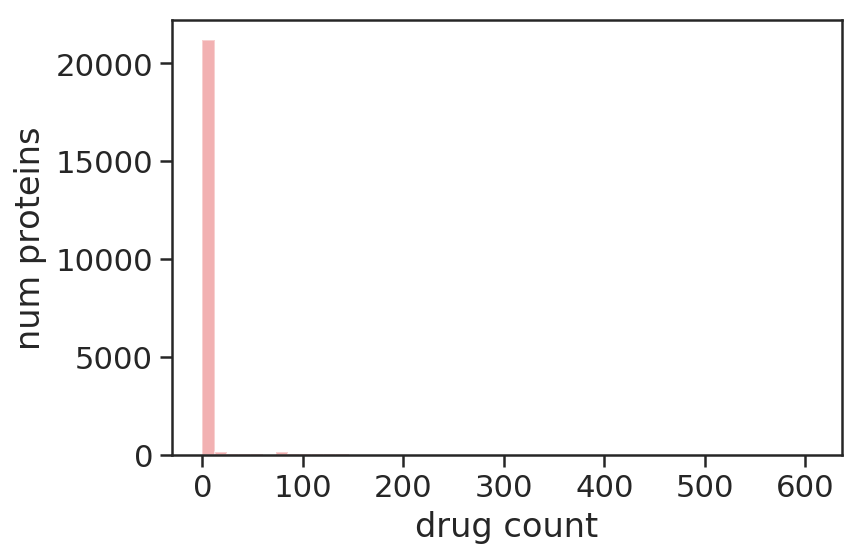

In [19]:
sns.distplot(all_drugs_exp.drug_counts, kde=False)
plt.yscale('linear')
plt.xlabel("drug count")
plt.ylabel("num proteins")

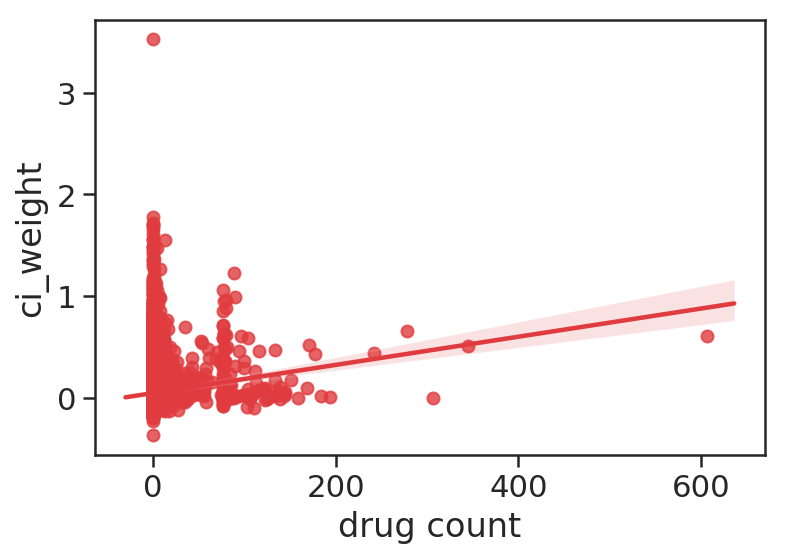

In [20]:
sns.regplot(all_drugs_exp.drug_counts, all_drugs_exp.ci_weights/np.sqrt(all_drugs_exp.degrees))
plt.xlabel("drug count")
plt.ylabel("ci_weight")
plt.xscale("linear")
plt.yscale('linear')

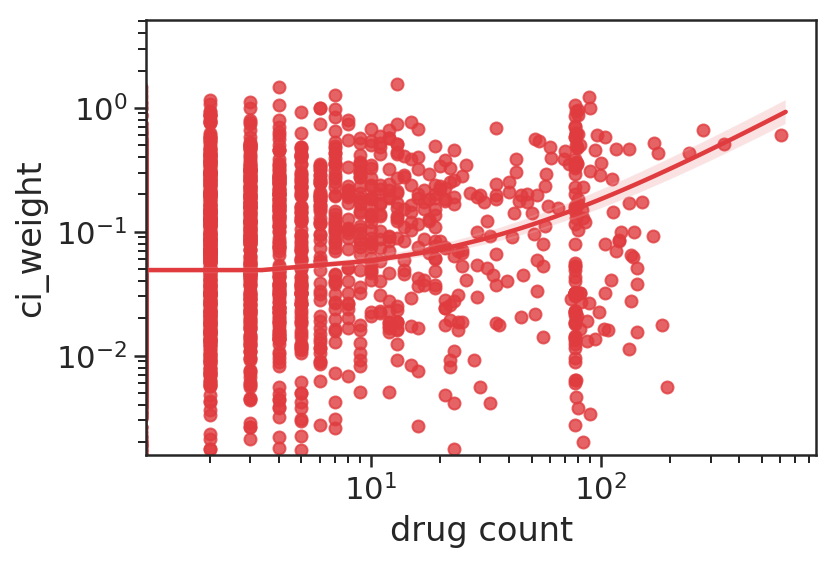

In [21]:
sns.regplot(all_drugs_exp.drug_counts, all_drugs_exp.ci_weights/np.sqrt(all_drugs_exp.degrees))
plt.xlabel("drug count")
plt.ylabel("ci_weight")
plt.xscale("log")
plt.yscale('log')

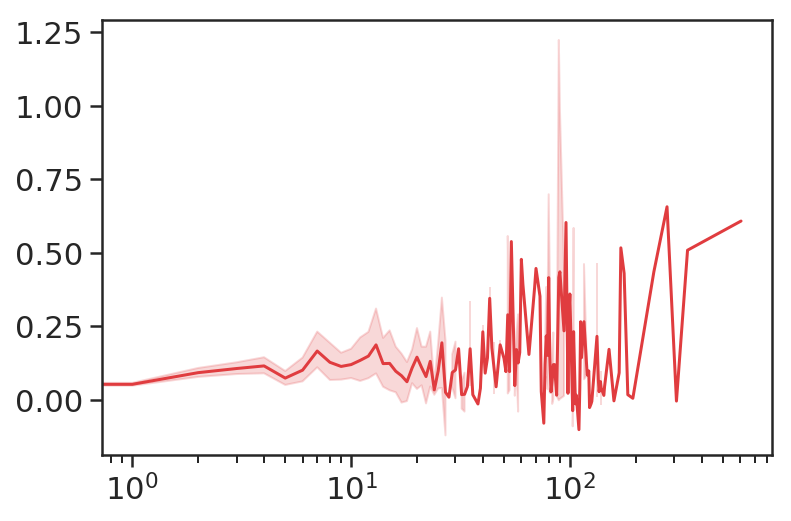

In [22]:
sns.lineplot(all_drugs_exp.drug_counts, all_drugs_exp.ci_weights/np.sqrt(all_drugs_exp.degrees))
plt.xscale('log')

In [23]:
# all proteins
all_drugs_exp.compute_weight_stats()

{'mean': 0.046297087609196215,
 'median': 0.01905014371925729,
 'std': 0.12643935388432098}

In [24]:
# targetted proteins
all_drugs_exp.compute_weight_stats(np.where(all_drugs_exp.drug_counts != 0))

{'mean': 0.07767503140960627,
 'median': 0.02037503384053707,
 'std': 0.1634200166301472}

In [25]:
# not targetted proteins
all_drugs_exp.compute_weight_stats(np.where(all_drugs_exp.drug_counts == 0))

{'mean': 0.03794204653499162,
 'median': 0.01881305182268994,
 'std': 0.11314030248033469}

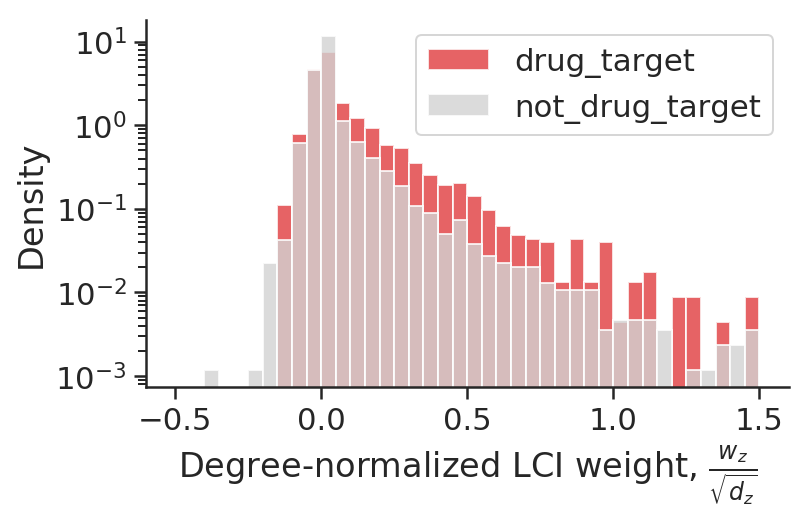

In [41]:
all_drugs_exp.plot_drug_weight_dist({"drug_target": np.where(all_drugs_exp.drug_counts > 0),
                                     "not_drug_target": np.where(all_drugs_exp.drug_counts == 0)})

In [27]:
top_proteins = np.argsort(all_drugs_exp.ci_weights_norm)[-500:]

In [28]:
all_drugs_exp.compute_frac_targets(top_proteins)

0.448

In [29]:
bottom_proteins = np.argsort(all_drugs_exp.ci_weights_norm)[:-500]

In [ ]:
all_drugs_exp.compute_frac_targets(bottom_proteins)

In [95]:
all_drugs_exp.frac_targets_ks_test(top_proteins, bottom_proteins)

Ks_2sampResult(statistic=0.24336496177043254, pvalue=7.778734195243265e-26)

In [177]:
all_drugs_exp.run()

True

#### CID Drugs

In [8]:
cid_drugs_exp = DrugTarget(
    dir="experiments/lci_analysis/cid_drug_target",
    params={**base_params, **{
        "drug_targets_path": "data/drug/cid_drug_targets.txt",
    }}
)

Loading disease associations...
Loading network...
Loading weights...
Loading drugs...


In [9]:
cid_drugs_exp.compute_drug_counts()

Text(0, 0.5, 'num proteins')

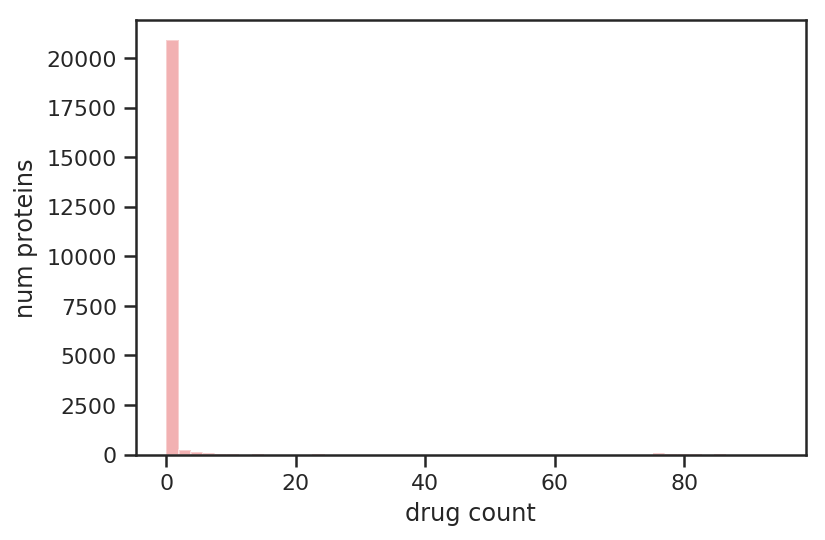

In [102]:
sns.distplot(cid_drugs_exp.drug_counts, kde=False)
plt.yscale('linear')
plt.xlabel("drug count")
plt.ylabel("num proteins")

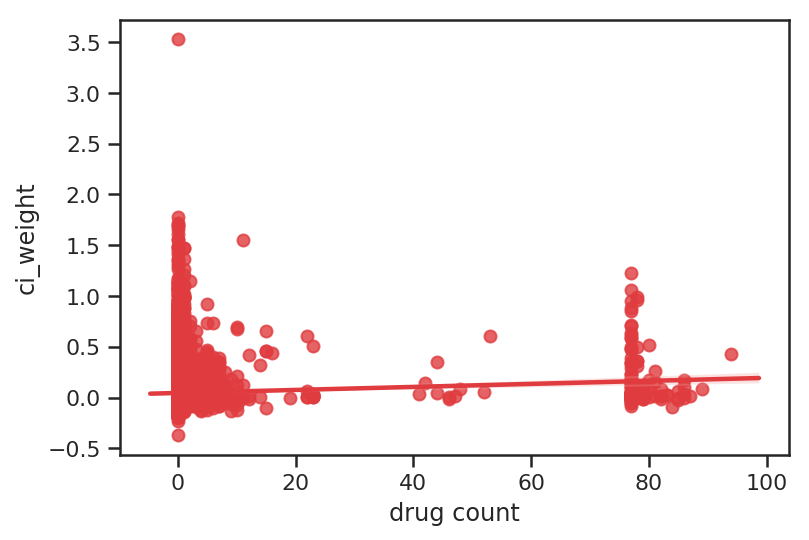

In [103]:
sns.regplot(cid_drugs_exp.drug_counts, cid_drugs_exp.ci_weights/np.sqrt(all_drugs_exp.degrees))
plt.xlabel("drug count")
plt.ylabel("ci_weight")
plt.xscale("linear")
plt.yscale('linear')

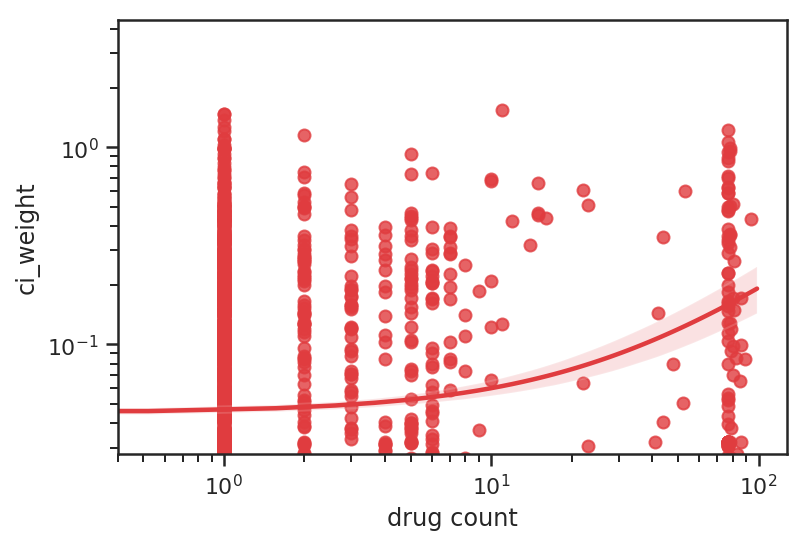

In [104]:
sns.regplot(cid_drugs_exp.drug_counts, cid_drugs_exp.ci_weights/np.sqrt(cid_drugs_exp.degrees))
plt.xlabel("drug count")
plt.ylabel("ci_weight")
plt.xscale("log")
plt.yscale('log')

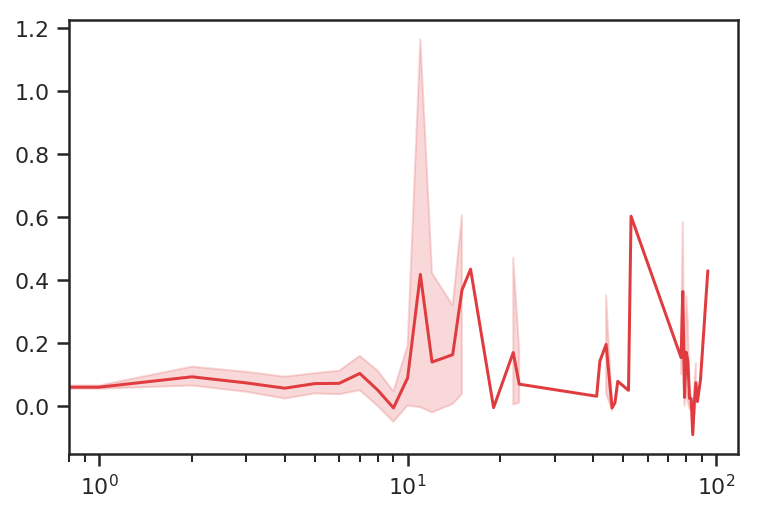

In [105]:
sns.lineplot(cid_drugs_exp.drug_counts, cid_drugs_exp.ci_weights/np.sqrt(cid_drugs_exp.degrees))
plt.xscale('log')

In [111]:
# all proteins
cid_drugs_exp.compute_weight_stats()

{'mean': 0.046297087609196215,
 'median': 0.01905014371925729,
 'std': 0.12643935388432098}

In [112]:
# targetted proteins
cid_drugs_exp.compute_weight_stats(np.where(cid_drugs_exp.drug_counts != 0))

{'mean': 0.0685163657260583,
 'median': 0.018142021398254386,
 'std': 0.15579819623183355}

In [113]:
# not targetted proteins
cid_drugs_exp.compute_weight_stats(np.where(cid_drugs_exp.drug_counts == 0))

{'mean': 0.04225212388994512,
 'median': 0.019421240595679342,
 'std': 0.11988409527949778}

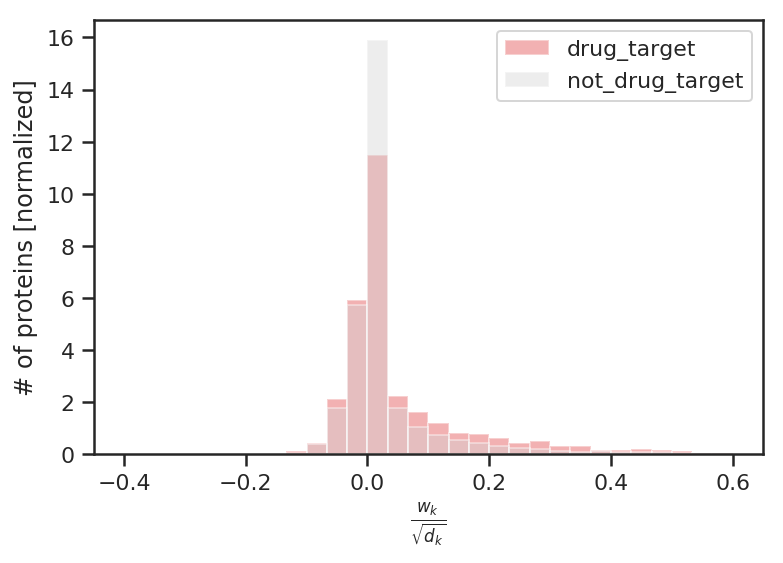

In [114]:
cid_drugs_exp.plot_drug_weight_dist({"drug_target": np.where(cid_drugs_exp.drug_counts > 0),
                                     "not_drug_target": np.where(cid_drugs_exp.drug_counts == 0)})

In [115]:
top_proteins = np.argsort(cid_drugs_exp.ci_weights_norm)[-500:]

In [116]:
cid_drugs_exp.compute_frac_targets(top_proteins)

0.272

In [117]:
bottom_proteins = np.argsort(cid_drugs_exp.ci_weights_norm)[:-500]

In [118]:
cid_drugs_exp.compute_frac_targets(bottom_proteins)

0.15120862421047632

In [119]:
cid_drugs_exp.frac_targets_ks_test(top_proteins, bottom_proteins)

Ks_2sampResult(statistic=0.1207913757895237, pvalue=1.0995139465330812e-06)

In [174]:
cid_drugs_exp.add_params({"top_k": 500})

In [175]:
cid_drugs_exp.run()

True

In [23]:
len(cid_drugs_exp.drug_to_targets)

284

In [ ]:
proteins

In [11]:
# compute average number of targets
num_targets = []
proteins = set()
for drug, targets in cid_drugs_exp.drug_to_targets.items():
    num_targets.append(len(targets))
    proteins.update(targets)
print(f"avg_num_targets: {np.mean(num_targets)}")
print(f"median_num_targets: {np.median(num_targets)}")
print(f"max_num_targets: {np.max(num_targets)}")
print(f"min_num_targets: {np.min(num_targets)}")
print(f"std_num_targets: {np.std(num_targets)}")

avg_num_targets: 65.80985915492958
median_num_targets: 11.0
max_num_targets: 2840
min_num_targets: 1
std_num_targets: 180.37966349172686


In [12]:
len(proteins)

3648

#### DB Drugs

In [6]:
from dpp.experiments.lci_analysis import DrugTarget
db_drugs_exp = DrugTarget(
    dir="experiments/lci_analysis/db_drug_target",
    params={**base_params, **{
        "drug_targets_path": "data/drug/db_drug_targets.txt",
    }}
)

Loading disease associations...
Loading network...
Loading weights...
Loading drugs...


In [7]:
db_drugs_exp.compute_drug_counts()

Text(0, 0.5, 'num proteins')

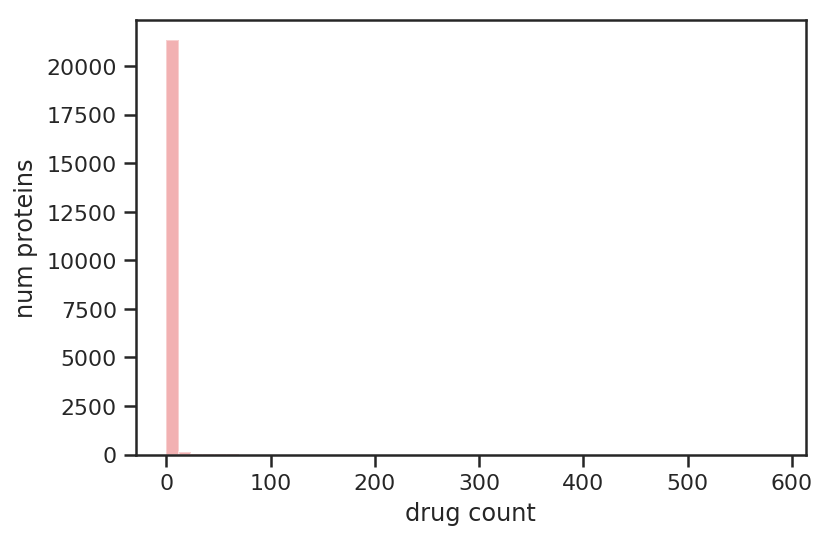

In [8]:
sns.distplot(db_drugs_exp.drug_counts, kde=False)
plt.yscale('linear')
plt.xlabel("drug count")
plt.ylabel("num proteins")

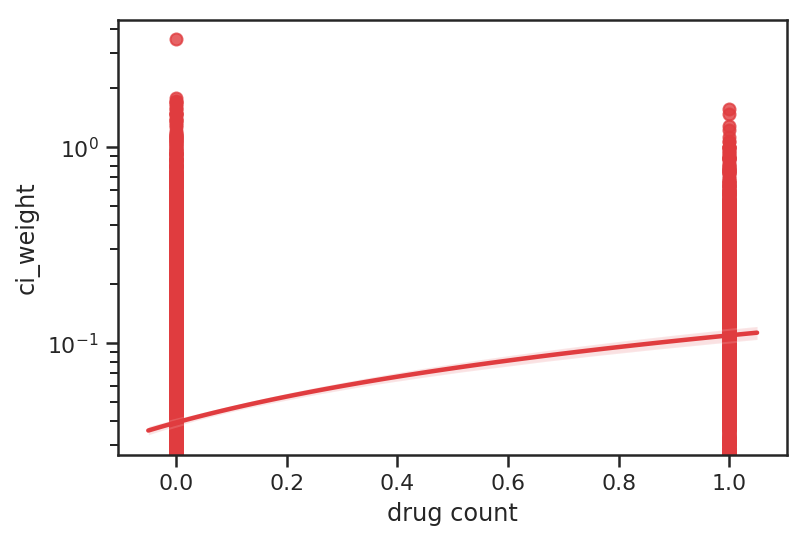

In [9]:
sns.regplot(db_drugs_exp.drug_counts != 0, db_drugs_exp.ci_weights/np.sqrt(db_drugs_exp.degrees))
plt.xlabel("drug count")
plt.ylabel("ci_weight")
plt.xscale("linear")
plt.yscale('log')

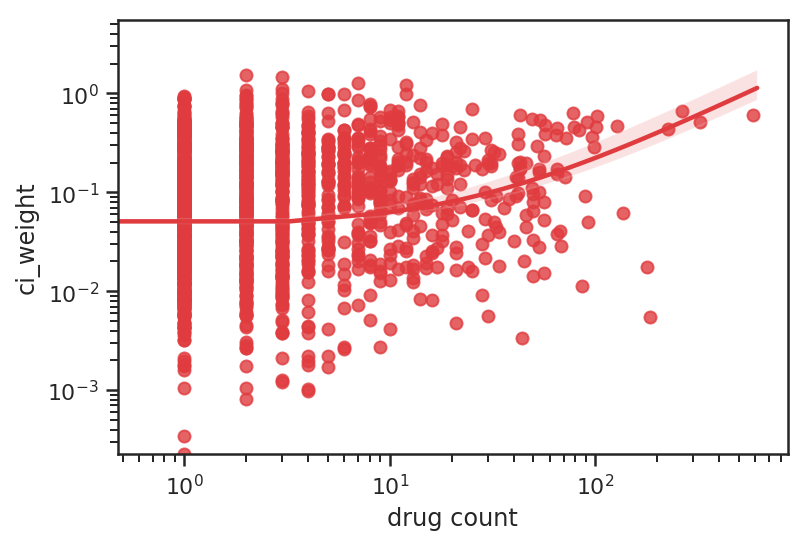

In [10]:
sns.regplot(db_drugs_exp.drug_counts, db_drugs_exp.ci_weights/np.sqrt(db_drugs_exp.degrees))
plt.xlabel("drug count")
plt.ylabel("ci_weight")
plt.xscale("log")
plt.yscale('log')

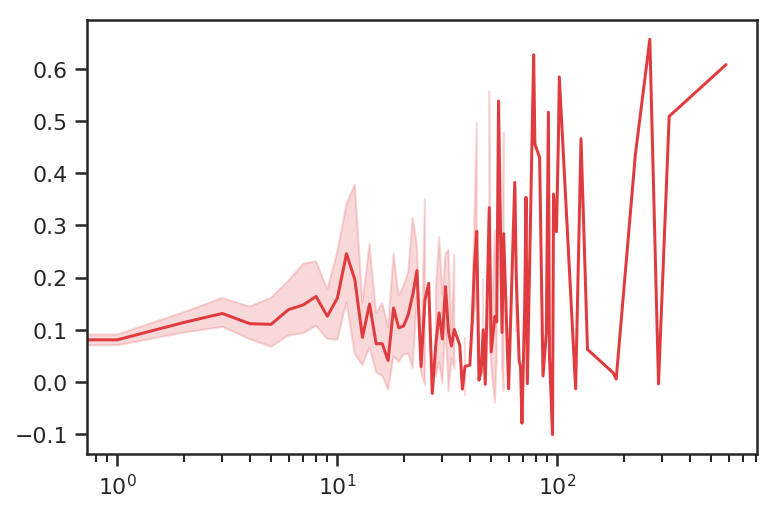

In [11]:
sns.lineplot(db_drugs_exp.drug_counts, db_drugs_exp.ci_weights/np.sqrt(db_drugs_exp.degrees))
plt.xscale('log')

In [12]:
# all proteins
db_drugs_exp.compute_weight_stats()

{'mean': 0.046297087609196215,
 'median': 0.01905014371925729,
 'std': 0.12643935388432098}

In [13]:
# targetted proteins
db_drugs_exp.compute_weight_stats(np.where(db_drugs_exp.drug_counts != 0))

{'mean': 0.10898323313357415,
 'median': 0.037927002779722954,
 'std': 0.1858858799271381}

In [14]:
# not targetted proteins
db_drugs_exp.compute_weight_stats(np.where(db_drugs_exp.drug_counts == 0))

{'mean': 0.039129253341947626,
 'median': 0.018487800259319037,
 'std': 0.11559934564168145}

In [15]:
len(np.where(db_drugs_exp.drug_counts > 0)[0])

2212

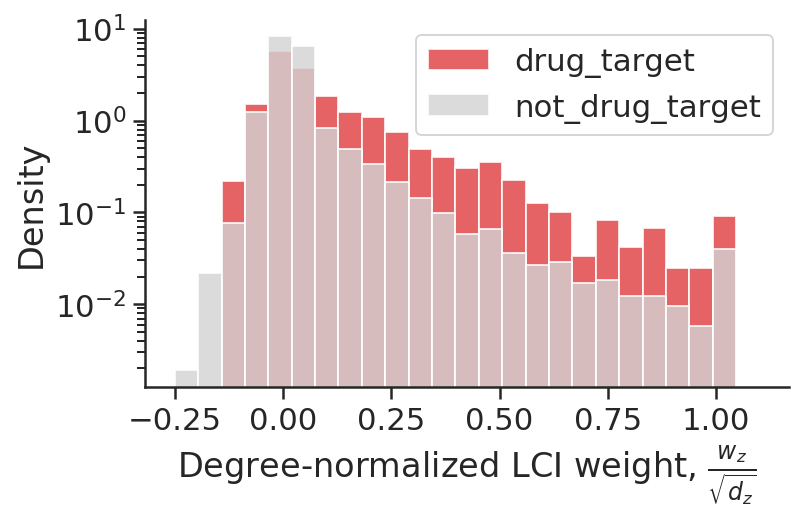

In [38]:
db_drugs_exp.plot_drug_weight_dist(protein_sets={"drug_target": np.where(db_drugs_exp.drug_counts > 0),
                                                 "not_drug_target": np.where(db_drugs_exp.drug_counts == 0)})

/Users/sabrieyuboglu/Documents/School/SNAP/projects/disease-protein-prediction/dpp/experiments/lci_analysis.py:173: RuntimeWarning: invalid value encountered in true_divide
  frac_hist = drug_hist / all_hist


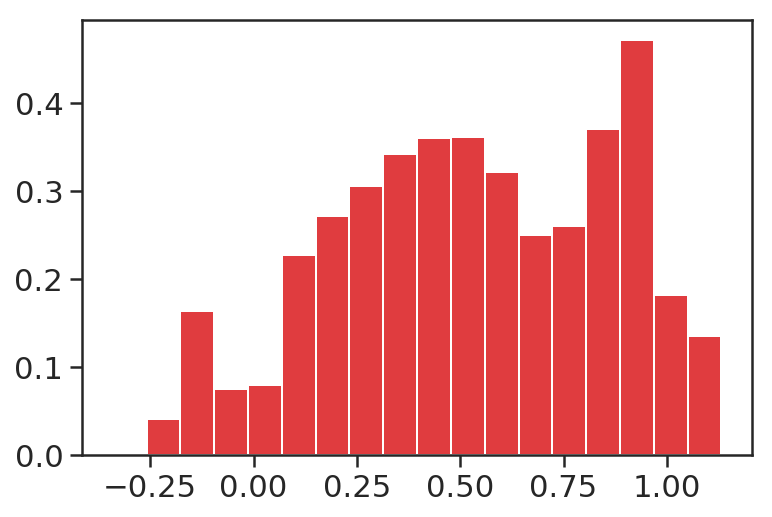

In [17]:
db_drugs_exp.plot_frac_drug_weight(protein_set=np.where(db_drugs_exp.drug_counts > 0))

In [21]:
top_proteins = np.argsort(db_drugs_exp.ci_weights_norm)[-500:]

In [160]:
db_drugs_exp.compute_frac_targets(top_proteins)

0.336

In [140]:
bottom_proteins = np.argsort(db_drugs_exp.ci_weights_norm)[:-500]

In [141]:
db_drugs_exp.compute_frac_targets(bottom_proteins)

0.09706985800446408

In [162]:
db_drugs_exp.frac_targets_ks_test(top_proteins, bottom_proteins).pvalue

6.435228672481076e-25

In [24]:
len(db_drugs_exp.drug_to_targets)

4994

In [ ]:
# compute average number of targets
num_targets = []
for drug, targets in db_drugs_exp.drug_to_targets.items():
    num_targets.append(len(targets))
print(f"avg_num_targets: {np.mean(num_targets)}")
print(f"median_num_targets: {np.median(num_targets)}")
print(f"max_num_targets: {np.max(num_targets)}")
print(f"min_num_targets: {np.min(num_targets)}")
print(f"std_num_targets: {np.std(num_targets)}")
sorted(num_targets, reverse=True)

In [170]:
db_drugs_exp.run()

True

### Essential Genes

In [2]:
# load essential genes
essential_proteins = []
with open("data/protein/essential.txt") as f:
    for line in f:
        line = line.strip(" \n")
        if line[0] == "#":
            continue
        
        entrez_id = int(line)
        essential_proteins.append(entrez_id)

In [3]:
from dpp.experiments.lci_analysis import EssentialGeneAnalysis

In [49]:
from dpp.data.protein import load_essential_proteins

In [53]:
ega = EssentialGeneAnalysis(
    dir="experiments/lci_analysis/essential",
    params={**base_params, **{
        "essential_genes_path": "data/protein/g_essential.tsv",
    }}
)

Loading disease associations...
Loading network...
Loading weights...
Loading essential genes...


In [25]:
len(ega.essential_nodes)

1491

In [65]:
ega.compute_weight_stats(norm=True)

{'mean': 0.046297087609196215,
 'median': 0.01905014371925729,
 'std': 0.12643935388432098}

In [66]:
ega.compute_weight_stats(ega.essential_nodes, norm=True)

{'mean': 0.03690980611891139,
 'median': 0.014307863221366339,
 'std': 0.0797905213291426}

In [67]:
ega.compute_weight_stats(ega.non_essential_nodes, norm=True)

{'mean': 0.04699460762823412,
 'median': 0.01943702535768745,
 'std': 0.1292080354788159}

In [43]:
essential_neighbors = np.dot(ega.essential_array, ega.network.adj_matrix) > 0

In [45]:
ega.compute_weight_stats(essential_neighbors)

{'mean': 0.04691694161673395,
 'median': 0.011273938459428806,
 'std': 0.12029159314245477}

In [38]:
bottom_proteins = np.argsort(ega.ci_weights_norm))[:21507]

In [39]:
ega.compute_frac_essential(top_proteins)

0.016

In [36]:
bottom_proteins = np.argsort(np.abs(ega.ci_weights_norm))[:21507]

In [37]:
ega.compute_frac_essential(bottom_proteins)

0.06932626586692704

In [69]:
ega.compute_weight_stats(ega.essential_nodes, norm=False)

{'mean': 0.38407975, 'median': 0.09166616, 'std': 0.7926507}

In [70]:
ega.compute_weight_stats(ega.non_essential_nodes, norm=False)

{'mean': 0.21666598, 'median': 0.031406447, 'std': 0.6472656}

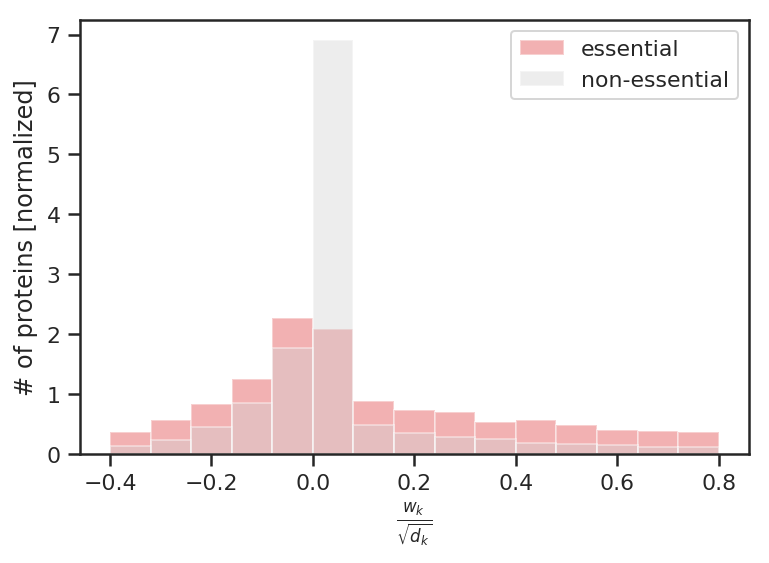

In [61]:
ega.plot_weight_dist({
    "essential": ega.essential_nodes,
    "non-essential": ega.non_essential_nodes
})

In [63]:
np.median(ega.degrees[ega.essential_nodes])

64.0

In [64]:
np.median(ega.degrees[ega.non_essential_nodes])

9.0

In [225]:
observed = (144 * 21.13)

In [227]:
expected = (144 * 20)

In [230]:
std = np.sqrt(1/5 * (4 * (0 - 0.2)**2 + (1- 0.2)**2))

In [233]:
(observed - expected) / (std * np.sqrt(14400))

3.3899999999999957